# Prepare the Environment

In [1]:
!pip install keras-tuner --upgrade

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 8.1 MB/s 
     |████████████████████████████████| 1.6 MB 54.9 MB/s 


# Download the Dataset

In [2]:
!gdown 1B-3Tl766omjqrHOsMxt_XFSiU1o_NhA2
!gdown 1P95lArIOy21L6JhPWj4M0rQ234xX0yq4

Downloading...
From: https://drive.google.com/uc?id=1B-3Tl766omjqrHOsMxt_XFSiU1o_NhA2
To: /content/train.zip
100% 621k/621k [00:00<00:00, 143MB/s]
Downloading...
From: https://drive.google.com/uc?id=1P95lArIOy21L6JhPWj4M0rQ234xX0yq4
To: /content/train_accessories_processed.zip
100% 529k/529k [00:00<00:00, 49.8MB/s]


Unzip and save the dataset in *tmp* folder

In [3]:
import os
import zipfile


zip_ref = zipfile.ZipFile("./train.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

zip_ref = zipfile.ZipFile("./train_accessories_processed.zip", 'r')
zip_ref.extractall("tmp/")
zip_ref.close()

os.remove("train.zip")
os.remove("train_accessories_processed.zip")

# Import Libraries

In [4]:
SEED = 42

import os
os.environ['TF_CUDNN_DETERMINISTIC'] = '1'

import random 
random.seed(SEED)

import numpy as np
np.random.seed(SEED)

import tensorflow as tf
tf.random.set_seed(SEED)

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

from PIL import Image, ImageOps
import cv2

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, confusion_matrix

import tensorflow.keras as keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import InputLayer, Dense
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from keras import backend as K

import keras_tuner as kt

%matplotlib inline

# Computation of the Eigenfaces

Set the size for training images

In [6]:
train_data_dir = "tmp/train"
DEFAULT_SIZE = [448, 448]

Convert images to list of numpy arrays and reshape these arrays as 1D column vectors.

In [7]:
def image_to_array(data_dir, default_size=DEFAULT_SIZE):
  images = []
  image_names = []
  for person in os.listdir(data_dir):
    person_dir = os.path.join(data_dir, person)
    for img_name in os.listdir(person_dir):
      image_names.append(img_name)
      image = Image.open(os.path.join(person_dir, img_name))
      image = ImageOps.exif_transpose(image)
      image = image.convert('L')  # greyscale
      image = image.resize(default_size)

      images.append(np.asarray(image, dtype=np.uint8).reshape(-1, 1))
        
  return [images, image_names]

In [8]:
[faces, names] = image_to_array(train_data_dir)

 Append face vectors to matrix

In [9]:
# assemble image to data matrix, each column is 1 image
face_matrix = np.empty((faces[0].size, 0), dtype=faces[0].dtype)
for face in faces:
  face_matrix = np.hstack((face_matrix, face)) # R*C x 1

Get the mean face

Text(0.5, 1.0, 'Mean Face')

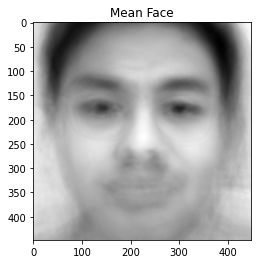

In [10]:
average_weight_matrix = face_matrix.mean(axis=1).reshape(DEFAULT_SIZE)
plt.imshow(average_weight_matrix, cmap=plt.cm.gray)
plt.title("Mean Face")

In [11]:
def num_of_principal_components(eigenvalues, variance=.95):
  for numofcomp, eigen_value_cumsum in enumerate(np.cumsum(eigenvalues) / np.sum(eigenvalues)):
    if eigen_value_cumsum > variance:
      return numofcomp

In [12]:
def pca(X):
  [rows, images] = X.shape
  num_components = rows
  mu = X.mean(axis=1, keepdims=True)
  X = X - mu

  # use smaller dimension C is covarience matrix
  if rows < images:
    C = np.matmul(X, X.T)
    [eigenvalues, eigenvectors] = np.linalg.eigh(C)
  else:
    C = np.matmul(X.T, X)
    [eigenvalues, eigenvectors] = np.linalg.eigh(C)
    eigenvectors = np.matmul(X, eigenvectors)
      
  # sort eigenvectors descending by their eigenvalue
  dxvalues = np.argsort(-eigenvalues)       # get order of index of highest - lowest eigenvalue as dxvalues
  eigenvalues = eigenvalues[dxvalues]       # sort eigenvalues by highest - lowest using index dxvalues
  eigenvectors = eigenvectors[:, dxvalues]  # do the same for eigenvectors
  pcomponents = num_of_principal_components(eigenvalues)
  eigenvalues = eigenvalues[0:pcomponents].copy()
  eigenvectors = eigenvectors[:, 0:pcomponents].copy()
  
  print(f'Number of Principal Components: {pcomponents}')
  print(f'Number of Eigenvalues: {eigenvalues.shape[0]}')
  print(f'Row x Col of Eigenvectors: {eigenvectors.shape}')
  
  return [eigenvalues, eigenvectors, mu]

In [13]:
[eigenvalues, eigenvectors, mean] = pca(face_matrix)

Number of Principal Components: 36
Number of Eigenvalues: 36
Row x Col of Eigenvectors: (200704, 36)


Print the first 16 eigenfaces with the highest eigenvalues

In [14]:
def subplot(title, images, rows, cols, sptitle="", sptitles=[], colormap=plt.cm.gray, filename=None, figsize=(10, 10)):
  fig = plt.figure(figsize=figsize)
  # main title
  fig.text(.5, .95, title, horizontalalignment='center')
  for i in range(len(images)):
    ax0 = fig.add_subplot(rows, cols, (i+1))
    plt.setp(ax0.get_xticklabels(), visible=False)
    plt.setp(ax0.get_yticklabels(), visible=False)

    if len(sptitles) == len(images):
      plt.title(f'{sptitle} #{str(sptitles[i])}')
    else:
      plt.title(f'{sptitle} #{i+1}')
    
    plt.imshow(np.asarray(images[i]), cmap=colormap)
      
  if filename is None :
    plt.show()
  else:
    fig.savefig(filename)

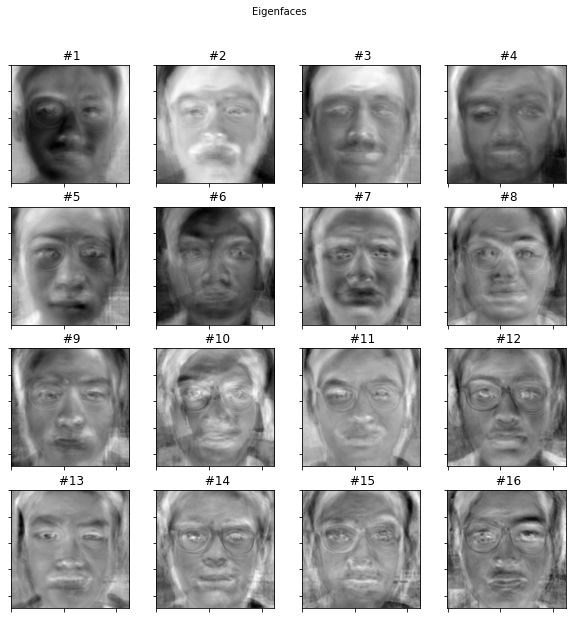

In [15]:
E = []
number = eigenvectors.shape[1]
for i in range(min(number, 16)):
  e = eigenvectors[:, i].reshape(DEFAULT_SIZE)
  E.append(np.asarray(e))

# plot them and save the plot
subplot(title="Eigenfaces", images=E, rows=4, cols=4, colormap=plt.cm.gray, filename="python_pca_eigenfaces.png")

In [16]:
def project(W, X, mu):                        
  return np.matmul(W.T, X - mu)

In [17]:
face_projections = []
for face in faces:
  face_projections.append(project(eigenvectors, face, mean)) # weight vector generation

# Face Recognition Using Eigenfaces

In [18]:
train_accessories_data_dir = "tmp/train_accessories_processed"
[accessory_faces, accessory_names] = image_to_array(train_accessories_data_dir)

accessory_face_projections = []
for face in accessory_faces:
  accessory_face_projections.append(project(eigenvectors, face, mean))

In [19]:
data = []
label = []
for i in range(len(face_projections)):
  for j in range(len(accessory_face_projections)):
    data.append(np.append(face_projections[i], accessory_face_projections[j]))
    label.append(1 if accessory_names[j][:-5] == names[i][:-5] else 0)

In [20]:
df = pd.DataFrame(data)
df['label'] = label
df

,0,1,2,3,4,5,6,7,8,9,...,63,64,65,66,67,68,69,70,71,label
0,-1.213579e+09,8.000540e+08,3.252115e+08,1.474738e+08,-2.564381e+08,1.683084e+07,-1.859344e+08,1.588896e+07,-4.704492e+07,1.230506e+08,...,-1.095321e+07,1.129383e+07,2.397209e+07,3.134768e+06,-3.899663e+07,-8.801816e+06,2.013014e+07,-3.237181e+07,1.084123e+07,1
1,-1.213579e+09,8.000540e+08,3.252115e+08,1.474738e+08,-2.564381e+08,1.683084e+07,-1.859344e+08,1.588896e+07,-4.704492e+07,1.230506e+08,...,-1.370283e+07,4.076246e+06,2.807788e+07,3.818665e+06,-3.351669e+07,-6.618928e+06,1.818020e+07,-2.527702e+07,1.021896e+07,1
2,-1.213579e+09,8.000540e+08,3.252115e+08,1.474738e+08,-2.564381e+08,1.683084e+07,-1.859344e+08,1.588896e+07,-4.704492e+07,1.230506e+08,...,-6.337393e+06,2.569907e+07,4.007299e+07,-4.942011e+06,-3.978158e+07,-1.707884e+07,1.410010e+07,-2.726317e+07,1.824627e+07,0
3,-1.213579e+09,8.000540e+08,3.252115e+08,1.474738e+08,-2.564381e+08,1.683084e+07,-1.859344e+08,1.588896e+07,-4.704492e+07,1.230506e+08,...,-4.120658e+06,2.801334e+07,3.768108e+07,-8.374402e+06,-3.899831e+07,-1.350504e+07,1.691507e+07,-2.834782e+07,1.853816e+07,0
4,-1.213579e+09,8.000540e+08,3.252115e+08,1.474738e+08,-2.564381e+08,1.683084e+07,-1.859344e+08,1.588896e+07,-4.704492e+07,1.230506e+08,...,1.424515e+06,1.935724e+07,4.002635e+07,-8.900513e+06,-4.280118e+07,-2.417141e+07,1.390036e+07,-2.945556e+07,2.233808e+07,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3103,5.740107e+08,5.794978e+08,-1.907046e+07,-2.626981e+08,4.066873e+08,2.266238e+08,-1.548251e+07,6.080642e+05,-1.723478e+08,-3.490079e+07,...,-5.185749e+06,2.379729e+07,3.144732e+07,-1.373990e+06,-2.995131e+07,-4.590201e+06,8.983644e+06,-1.405566e+07,1.578484e+07,0
3104,5.740107e+08,5.794978e+08,-1.907046e+07,-2.626981e+08,4.066873e+08,2.266238e+08,-1.548251e+07,6.080642e+05,-1.723478e+08,-3.490079e+07,...,-1.051792e+07,1.471089e+07,2.894940e+07,-8.700986e+05,-3.735712e+07,-8.275384e+06,1.538460e+07,-2.927125e+07,9.789974e+06,0
3105,5.740107e+08,5.794978e+08,-1.907046e+07,-2.626981e+08,4.066873e+08,2.266238e+08,-1.548251e+07,6.080642e+05,-1.723478e+08,-3.490079e+07,...,-9.900741e+06,1.968598e+07,2.648060e+07,6.252194e+06,-3.929634e+07,-6.005400e+06,1.140767e+07,-1.969495e+07,7.057819e+06,0
3106,5.740107e+08,5.794978e+08,-1.907046e+07,-2.626981e+08,4.066873e+08,2.266238e+08,-1.548251e+07,6.080642e+05,-1.723478e+08,-3.490079e+07,...,-1.292974e+07,2.396087e+07,3.724707e+07,-2.158991e+07,-4.063876e+07,-1.828791e+07,2.676766e+07,-3.340814e+07,2.023306e+07,0


In [21]:
def split_dataset(df, columns_to_drop, test_size, random_state):
  df_train, df_test = train_test_split(df, test_size=test_size, random_state=random_state)

  df_train2 = df_train.drop(columns_to_drop, axis=1)
  y_train2 = df_train['label'].to_numpy()

  df_test2 = df_test.drop(columns_to_drop, axis=1)
  y_test2 = df_test['label'].to_numpy() 

  return df_train2, y_train2, df_test2, y_test2

def preprocess_dataset(df_train, df_test):
  standard_scaler = preprocessing.StandardScaler()

  df_train_scaled = standard_scaler.fit_transform(df_train)
  df_test_scaled = standard_scaler.transform(df_test)

  return df_train_scaled, df_test_scaled

In [22]:
columns_to_drop = ['label']

X_train, y_train, X_test, y_test = split_dataset(df, columns_to_drop, test_size=0.2, random_state=42) # positive labels being encoded as 1

X_train_scaled, X_test_scaled = preprocess_dataset(X_train, X_test)

In [23]:
class EigenfaceHyperModel(kt.HyperModel):
  def build(self, hp):
    model = Sequential()
    model.add(InputLayer(input_shape=(X_train.shape[1], )))
    model.add(Dense(units=hp.Int("layer1_units", min_value=32, max_value=64, step=8), activation='relu'))
    model.add(Dense(units=hp.Int("layer2_units", min_value=8, max_value=16, step=4), activation='relu'))
    model.add(Dense(units=1, activation='sigmoid'))

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp.Float("learning_rate", min_value=1e-4, max_value=2e-1, sampling='log')),
                  loss=keras.losses.BinaryCrossentropy(),
                  metrics=['accuracy'])
    
    return model

  def fit(self, hp, model, *args, **kwargs):
    return model.fit(*args,
                     batch_size=hp.Choice("batch_size", [16, 32]),
                     **kwargs)

In [24]:
tuner = kt.RandomSearch(EigenfaceHyperModel(),
                        objective='val_loss',
                        max_trials=50,
                        overwrite=True)

In [25]:
escb = EarlyStopping(monitor='val_loss', patience=10)

In [26]:
tuner.search(X_train_scaled, y_train,
             epochs=100,
             verbose=1,
             callbacks=[escb],
             validation_data=(X_test_scaled, y_test))

Trial 50 Complete [00h 00m 03s]
val_loss: 0.03996947407722473

Best val_loss So Far: 0.006194681394845247
Total elapsed time: 00h 09m 25s


In [27]:
tuner.results_summary()

Results summary
Results in ./untitled_project
Showing 10 best trials
Trial summary
Hyperparameters:
layer1_units: 56
layer2_units: 12
learning_rate: 0.014770508317353371
batch_size: 16
Score: 0.006194681394845247
Trial summary
Hyperparameters:
layer1_units: 56
layer2_units: 8
learning_rate: 0.005754006150265794
batch_size: 16
Score: 0.00966141652315855
Trial summary
Hyperparameters:
layer1_units: 40
layer2_units: 12
learning_rate: 0.0051029272353161174
batch_size: 16
Score: 0.010432367213070393
Trial summary
Hyperparameters:
layer1_units: 40
layer2_units: 12
learning_rate: 0.05888615214636587
batch_size: 32
Score: 0.011412215419113636
Trial summary
Hyperparameters:
layer1_units: 56
layer2_units: 12
learning_rate: 0.012799351671716008
batch_size: 16
Score: 0.011724150739610195
Trial summary
Hyperparameters:
layer1_units: 32
layer2_units: 16
learning_rate: 0.008479772879135433
batch_size: 16
Score: 0.01345368567854166
Trial summary
Hyperparameters:
layer1_units: 64
layer2_units: 16
learn

In [28]:
best_hps = tuner.get_best_hyperparameters()[0]

In [29]:
hypermodel = EigenfaceHyperModel()
best_model = hypermodel.build(best_hps)
best_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 56)                4088      
                                                                 
 dense_4 (Dense)             (None, 12)                684       
                                                                 
 dense_5 (Dense)             (None, 1)                 13        
                                                                 
Total params: 4,785
Trainable params: 4,785
Non-trainable params: 0
_________________________________________________________________


In [30]:
history = best_model.fit(X_train_scaled, y_train,
                         batch_size=16,
                         epochs=100,
                         verbose=1,
                         callbacks=[escb],
                         validation_data=(X_test_scaled, y_test))

Epoch 1/100
156/156 [==============================] - 1s 3ms/step - loss: 0.2206 - accuracy: 0.9409 - val_loss: 0.1456 - val_accuracy: 0.9518
Epoch 2/100
156/156 [==============================] - 0s 2ms/step - loss: 0.1046 - accuracy: 0.9578 - val_loss: 0.0797 - val_accuracy: 0.9711
Epoch 3/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0376 - accuracy: 0.9859 - val_loss: 0.0505 - val_accuracy: 0.9823
Epoch 4/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0408 - accuracy: 0.9887 - val_loss: 0.2958 - val_accuracy: 0.9566
Epoch 5/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0789 - accuracy: 0.9811 - val_loss: 0.0468 - val_accuracy: 0.9920
Epoch 6/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0178 - accuracy: 0.9932 - val_loss: 0.0313 - val_accuracy: 0.9887
Epoch 7/100
156/156 [==============================] - 0s 2ms/step - loss: 0.0056 - accuracy: 0.9996 - val_loss: 0.0217 - val_accuracy: 0.9936

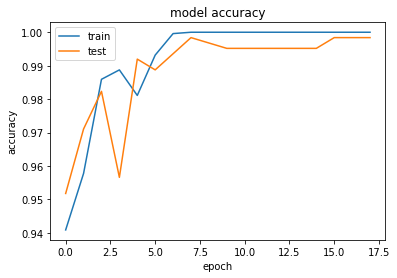

In [31]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

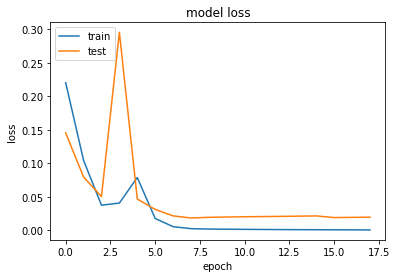

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# Prediction of unknown faces